In [1]:
!pip install yfinance --quiet

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [74]:
symbol = "TATAMOTORS.NS"  # Volatile stock for visible SMA crossovers
start_date = "2020-01-01"
end_date = "2024-01-01"

df = yf.download(symbol, start=start_date, end=end_date)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df = df[['Close']]
print("Downloaded data. Sample:")
display(df.head())

/tmp/ipython-input-74-3344956248.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded data. Sample:


Price,Close
Date,
2020-01-01,182.309433
2020-01-02,191.501526
2020-01-03,188.882278
2020-01-06,183.495514
2020-01-07,182.556549


In [75]:
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_15'] = df['Close'].rolling(window=15).mean()
df['Signal'] = np.where(df['SMA_5'] > df['SMA_15'], 1, 0)
df['Position'] = df['Signal'].diff()
print(df.columns.tolist())

# Step 4: NOW drop NaNs safely
df.dropna(subset=['SMA_5', 'SMA_15', 'Signal', 'Position'], inplace=True)
df.reset_index(drop=True, inplace=True)

['Close', 'SMA_5', 'SMA_15', 'Signal', 'Position']


In [76]:
#  Create signals
df['Signal'] = np.where(df['SMA_5'] > df['SMA_15'], 1, 0)
df['Position'] = df['Signal'].diff()

# Drop any row that has NaN in any of these columns
df.dropna(subset=['SMA_5', 'SMA_15', 'Signal', 'Position'], inplace=True)

# Reset index to ensure clean iteration
df.reset_index(drop=True, inplace=True)
print("Buy signals:", (df['Position'] == 1).sum())
print("Sell signals:", (df['Position'] == -1).sum())

Buy signals: 36
Sell signals: 36


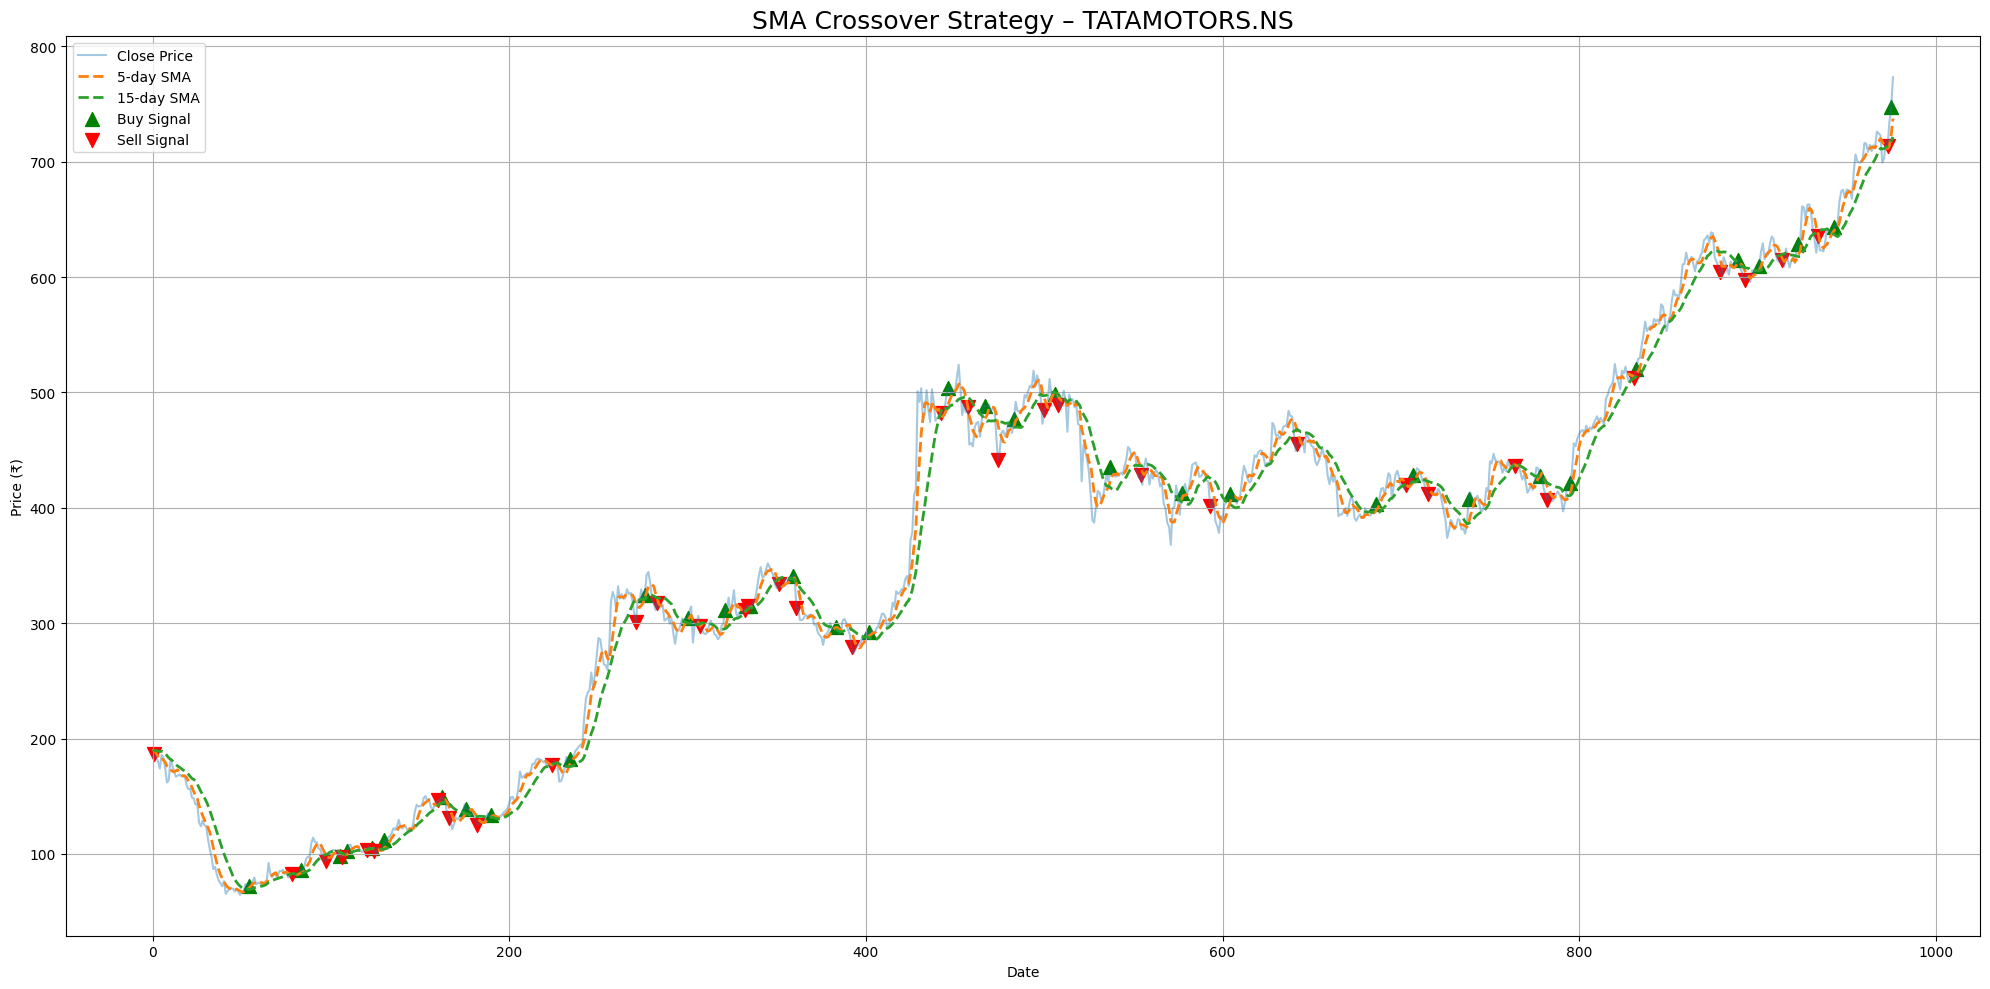

In [77]:
# ---------------------------------------
# Plot SMAs + Buy/Sell Markers
# ---------------------------------------

plt.figure(figsize=(20,10))
plt.plot(df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['SMA_5'], label='5-day SMA', linewidth=2, linestyle='--')
plt.plot(df['SMA_15'], label='15-day SMA', linewidth=2, linestyle='--')

plt.scatter(df[df['Position'] == 1].index, df['Close'][df['Position'] == 1],
            label='Buy Signal', marker='^', color='green', s=100)

plt.scatter(df[df['Position'] == -1].index, df['Close'][df['Position'] == -1],
            label='Sell Signal', marker='v', color='red', s=100)

plt.title(f"SMA Crossover Strategy – {symbol}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# Trade Simulation — FIXED, CLEAN
initial_cash = 100000.0
cash = initial_cash
position = 0.0
buy_price = 0.0
portfolio_value = []
trade_log = []
returns = []

for i in range(len(df)):
    price = df['Close'].iloc[i]
    signal = df['Position'].iloc[i]
    date = df.index[i]

    if signal == 1 and cash > 0:
        # BUY
        buy_price = price
        position = cash / price
        cash = 0.0
        trade_log.append(('BUY', date, price))

    elif signal == -1 and position > 0:
        # SELL
        sell_price = price
        cash = position * sell_price
        profit = (sell_price - buy_price) / buy_price
        returns.append(profit)
        trade_log.append(('SELL', date, price))
        position = 0.0

    # Track portfolio value at each step
    total_value = cash + (position * price)
    portfolio_value.append(total_value)

In [79]:
print("Buy signals:", (df['Position'] == 1).sum())
print("Sell signals:", (df['Position'] == -1).sum())

Buy signals: 36
Sell signals: 36


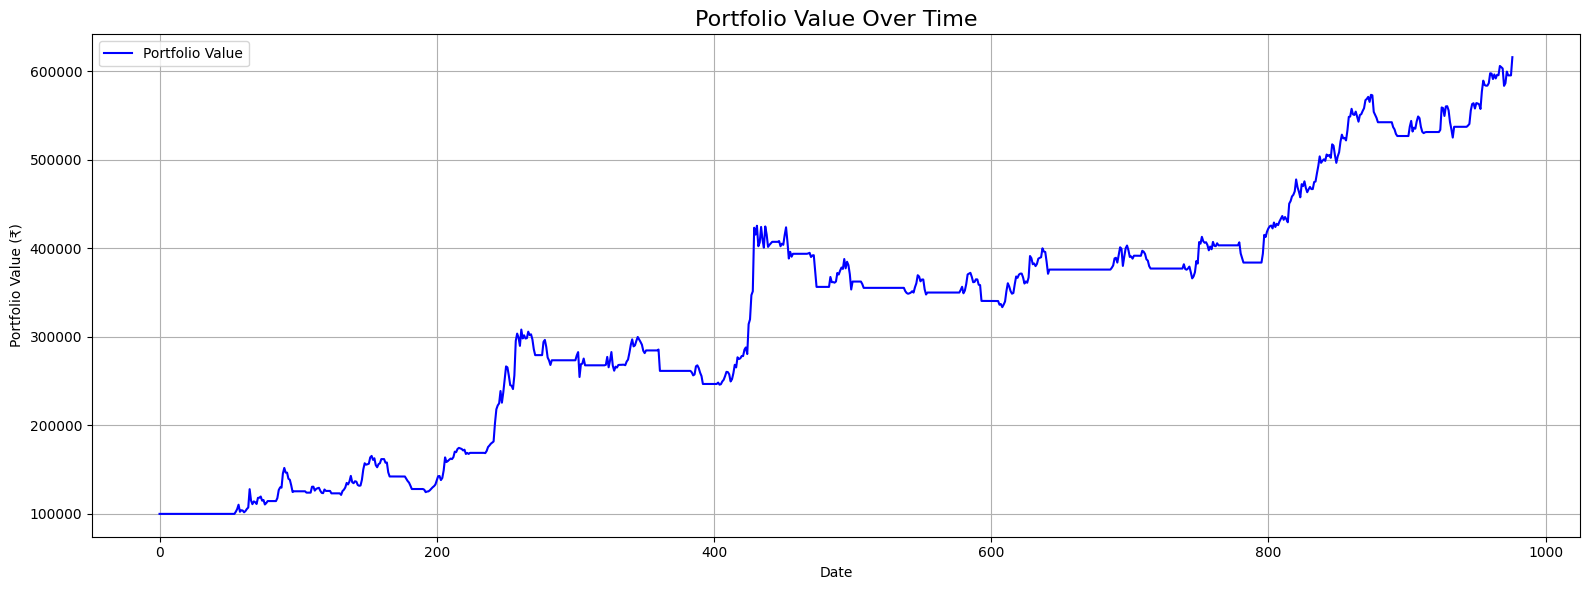

In [80]:
# Match length
portfolio_value = portfolio_value[-len(df):]

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_value, label='Portfolio Value', color='blue')
plt.title("Portfolio Value Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [81]:
print(" TRADE LOG\n")

if len(trade_log) == 0:
    print("⚠️ No trades were executed.")
else:
    for action, date, price in trade_log:
        formatted_date = date.strftime('%Y-%m-%d') if hasattr(date, 'strftime') else str(date)
        print(f"{action:>4} on {formatted_date} at ₹{price:.2f}")

# Portfolio summary
final_value = float(portfolio_value[-1])
net_profit = final_value - initial_cash

total_trades = len([x for x in trade_log if x[0] == 'BUY'])
win_trades = len([r for r in returns if r > 0])
loss_trades = len([r for r in returns if r <= 0])
win_rate = (win_trades / total_trades) * 100 if total_trades else 0

print("\n FINAL REPORT")
print(f"Final Portfolio Value: ₹{final_value:.2f}")
print(f"Net Profit: ₹{net_profit:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {win_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Return: {(net_profit / initial_cash) * 100:.2f}%")

 TRADE LOG

 BUY on 54 at ₹72.05
SELL on 78 at ₹82.48
 BUY on 83 at ₹85.99
SELL on 97 at ₹94.29
 BUY on 105 at ₹98.30
SELL on 106 at ₹97.11
 BUY on 109 at ₹102.25
SELL on 120 at ₹103.83
 BUY on 123 at ₹104.82
SELL on 124 at ₹102.55
 BUY on 130 at ₹111.74
SELL on 160 at ₹146.83
 BUY on 162 at ₹149.69
SELL on 166 at ₹131.56
 BUY on 176 at ₹139.36
SELL on 182 at ₹125.48
 BUY on 190 at ₹134.08
SELL on 224 at ₹176.82
 BUY on 234 at ₹182.01
SELL on 271 at ₹300.97
 BUY on 276 at ₹324.49
SELL on 283 at ₹317.72
 BUY on 300 at ₹304.23
SELL on 307 at ₹297.90
 BUY on 321 at ₹311.20
SELL on 332 at ₹311.84
 BUY on 333 at ₹314.90
SELL on 334 at ₹315.05
 BUY on 335 at ₹315.05
SELL on 351 at ₹333.98
 BUY on 359 at ₹340.90
SELL on 361 at ₹313.22
 BUY on 383 at ₹296.57
SELL on 392 at ₹279.81
 BUY on 402 at ₹292.12
SELL on 442 at ₹482.19
 BUY on 446 at ₹503.74
SELL on 457 at ₹487.03
 BUY on 467 at ₹488.22
SELL on 474 at ₹441.86
 BUY on 483 at ₹476.80
SELL on 500 at ₹484.86
 BUY on 506 at ₹498.65
SELL on 5